In [1]:
import torch
import pandas as pd
import numpy as np

In [2]:
path = "/kaggle/input/eeg-data/eeg_signals_raw_with_mean_std.pth"

dataset = torch.load(path)

In [3]:
type(dataset)

dict

In [4]:

# split dictionary into keys and values
keys = []
values = []
items = dataset.items()
for item in items:
    keys.append(item[0]), values.append(item[1])

# printing keys and values separately
print("keys : ", str(keys))

keys :  ['dataset', 'labels', 'images', 'means', 'stddevs']


In [5]:
# for i in range(0,5):
#     print(values[i].shape)
values[3].shape

torch.Size([128, 1])

In [6]:
# import the modules
import os
from os import listdir

# get the path/directory
folder_dir = "/kaggle/input/eeg-preprocessing/imageNet_images"
img_path_list = {}
count = 0
for dir in os.listdir(folder_dir):
    for images in os.listdir(f"/kaggle/input/eeg-preprocessing/imageNet_images/{dir}"):
    
        # check if the image ends with png
        if (images.endswith(".JPEG")):
            count +=1
            img_path_list[images[:-5]] = images
            #print(images)

print(count)


1996


In [7]:
for i in values[0]:
    i['eeg'] = i['eeg'].numpy()

In [8]:
len(values[0])

11965

In [9]:
values[0][8]['eeg'].shape

(128, 497)

In [10]:
keys[1]

'labels'

In [11]:
data = pd.DataFrame(values[0])
data.tail(20)

,eeg,image,label,subject
11945,"[[-2, 11, 25, 35, 44, 50, 53, 51, 42, 28, 13, ...",1976,38,5
11946,"[[9, 0, -6, -11, -14, -15, -11, -4, 4, 14, 24,...",1977,15,5
11947,"[[-46, -57, -65, -72, -77, -79, -77, -71, -61,...",1978,24,5
11948,"[[-15, -3, 8, 19, 29, 37, 43, 45, 41, 31, 18, ...",1979,25,5
11949,"[[29, 19, 9, 0, -8, -15, -21, -24, -23, -19, -...",1980,12,5
11950,"[[29, 36, 41, 41, 35, 25, 13, 0, -12, -25, -36...",1981,32,5
11951,"[[-6, -15, -24, -31, -36, -39, -40, -37, -33, ...",1982,35,5
11952,"[[45, 40, 31, 20, 9, 0, -8, -14, -20, -25, -27...",1983,4,5
11953,"[[-39, -42, -41, -35, -26, -14, -2, 9, 19, 27,...",1984,28,5
11954,"[[39, 39, 34, 24, 11, 0, -10, -18, -22, -25, -...",1985,12,5


In [12]:
import mne

In [13]:
values[0][0]['eeg'].shape[1]

500

In [14]:
import numpy as np
from scipy.signal import butter, sosfiltfilt

def bandpass_filter(data, lowcut=5, highcut=95, fs=1000, order=4):
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    filtered = sosfiltfilt(sos, data, axis=-1)  # filters along time axis
    return filtered


In [15]:
data['eeg'] = data['eeg'].apply(lambda x: bandpass_filter(x))

In [16]:
def zscore_normalize(eeg):
    mean = np.mean(eeg, axis=1, keepdims=True)
    std = np.std(eeg, axis=1, keepdims=True)
    return (eeg - mean) / (std + 1e-8)  # small epsilon for numerical stability

In [17]:
data['eeg'] = data['eeg'].apply(lambda x: zscore_normalize(x))

In [18]:
data.head()

,eeg,image,label,subject
0,"[[0.1691649952469654, 0.278952532277858, 0.412...",0,10,4
1,"[[0.14471041327772954, 0.05174374015299359, 0....",1,30,4
2,"[[0.17683173146079828, 0.32955090757685834, 0....",2,29,4
3,"[[-0.032953388138596953, 0.39959952498532564, ...",3,10,4
4,"[[0.15286577122378844, 0.3928599729613496, 0.6...",4,30,4


In [19]:
def tokenize_time_series(data, token_length=4):
    _, L = data.shape
    
    # Pad L to be divisible by token_length
    pad_length = (token_length - (L % token_length)) % token_length
    if pad_length > 0:
        padded_data = np.pad(data, ((0, 0), (0, pad_length)), mode='edge')  # Replicate edge values
    else:
        padded_data = data
    
    # Reshape into tokens
    num_tokens = padded_data.shape[1] // token_length
    tokens = padded_data.reshape(128, num_tokens, token_length)  # (128, num_tokens, 4)
    tokens = np.transpose(tokens, (1, 0, 2))  # (num_tokens, 128, 4)
    
    return tokens

In [20]:
processed_data = pd.DataFrame(data['eeg'].apply(lambda x : tokenize_time_series(x)))

In [21]:
import torch
import torch.nn as nn

# Projection layer (512 → 1024)
projection = nn.Linear(128 * 4, 1024)  # Each token is (128, 4) → flattened to 512

def embed(tokens):
    all_embeddings = []
    tokens = torch.tensor(tokens, dtype=torch.float32)
    flattened = tokens.reshape(-1, 128 * 4)  # (num_tokens, 512)
    embeddings = projection(flattened)
    all_embeddings.append(embeddings)
    return all_embeddings

In [22]:
type(processed_data['eeg'][0])

numpy.ndarray

In [23]:
processed_data['embeddings'] = processed_data['eeg'].apply(lambda x : embed(x))

In [33]:
processed_data['embeddings'][0][0].shape

torch.Size([125, 1024])

In [44]:
data['eeg'][0][0].shape


(500,)

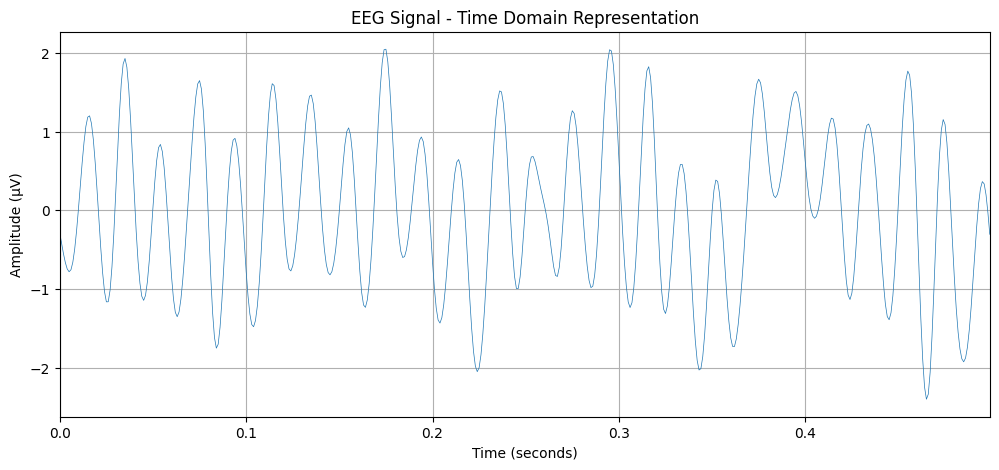

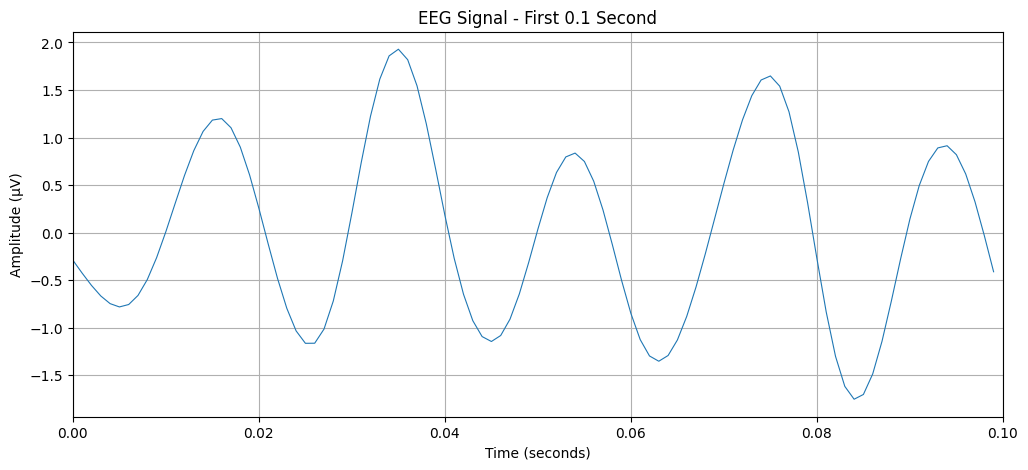

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling frequency (Hz)
fs = 1000.0  

# Create time array based on the length of your EEG data
eeg_signal = data['eeg'][0][5]  # Your EEG time series
n_samples = len(eeg_signal)
time = np.arange(n_samples) / fs  # Time in seconds

# Plot settings
plt.figure(figsize=(12, 5))
plt.plot(time, eeg_signal, linewidth=0.5)  # Thin line for dense EEG data
plt.xlim([time[0], time[-1]])  # Show full duration
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')  # Assuming EEG is in microvolts
plt.title('EEG Signal - Time Domain Representation')
plt.grid(True)

#Plot of a segment
plt.figure(figsize=(12, 5))
segment_length = 0.1  # Show 0.1-second segment
plt.plot(time[:int(segment_length*fs)], eeg_signal[:int(segment_length*fs)], linewidth=0.8)
plt.xlim([0, segment_length])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (μV)')
plt.title(f'EEG Signal - First {segment_length} Second')
plt.grid(True)

plt.show()

In [ ]:


n = len(eeg_signal)  # Number of samples
fft_result = np.fft.fft(eeg_signal)  # Compute FFT
frequencies = np.fft.fftfreq(n, d=1/fs)  # Frequency bins

# Take only the positive frequencies (since FFT is symmetric)
half_n = n // 2
positive_freq = frequencies[:half_n]
magnitude = np.abs(fft_result[:half_n])  # Magnitude spectrum

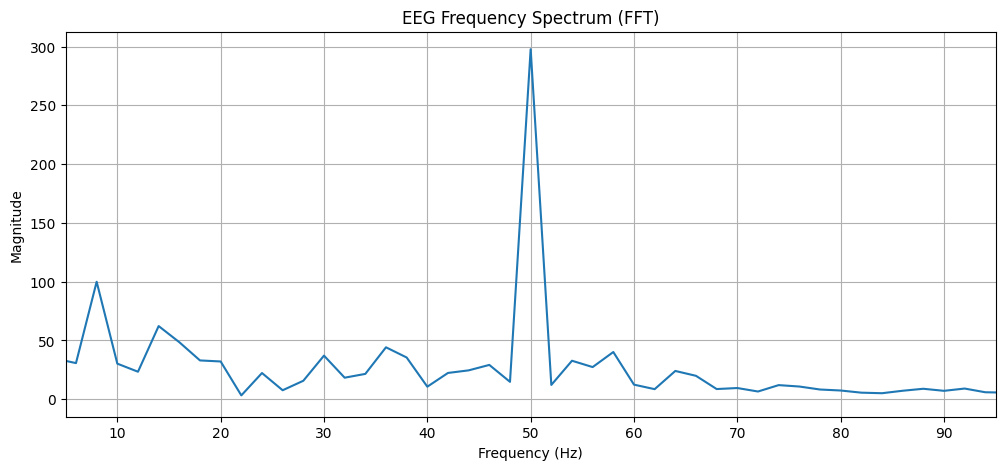

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(positive_freq, magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('EEG Frequency Spectrum (FFT)')
plt.xlim(5, 95)
plt.grid(True)
plt.show()